# Import Libraries and Dataset

In [1]:
!pip install --upgrade seaborn
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
# Load Kaggle Datasets into Google Colab
# Note: Load kaggle.json file
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download awsaf49/vinbigdata-512-image-dataset
!kaggle datasets download awsaf49/vinbigdata-yolo-labels-dataset

100% 2.29G/2.30G [01:18<00:00, 22.5MB/s]
100% 2.30G/2.30G [01:18<00:00, 31.4MB/s]
100% 4.85M/4.85M [00:00<00:00, 24.4MB/s]
100% 4.85M/4.85M [00:00<00:00, 24.3MB/s]


In [4]:
!unzip /content/vinbigdata-512-image-dataset.zip
!unzip /content/vinbigdata-yolo-labels-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: labels/a9f32aee073a0ee7ea94e959ab63885c.txt  
  inflating: labels/a9f467688d104d27583ea3b3154b1f30.txt  
  inflating: labels/a9f4c9a4971b3877981e09d4a2ac7fc0.txt  
  inflating: labels/a9f60e50925ece0b5c00b6bbd9f0825c.txt  
  inflating: labels/aa0202259a3cba71d0e72468e2d9c3e2.txt  
  inflating: labels/aa08370eb6114a474adfd0accb6a7238.txt  
  inflating: labels/aa0a24df022cd97cc1dff4f7ea2131cc.txt  
  inflating: labels/aa0b79c06462e126d97b73a15187c9c4.txt  
  inflating: labels/aa1203b1ecab0cddec19f07eb68d4dee.txt  
  inflating: labels/aa12ea6652b3b8bea37df74e4e127e8f.txt  
  inflating: labels/aa161d1deb918990c3e196501a714994.txt  
  inflating: labels/aa1758ce7d9f3cb0bbba72d163ffc69a.txt  
  inflating: labels/aa17d5312a0fb4a2939436abca7f9579.txt  
  inflating: labels/aa1c58360809119ce5c2d081f590c67b.txt  
  inflating: labels/aa1ebd488f7f3cab0aa784073b0a9d70.txt  
  inflating: labels/aa20e108316a361edbb9e78ad50f2a8e.txt  
  inf

In [5]:
# check the number of files in the directory by Duong
import os
APP_FOLDER = '/content/labels'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
        
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/labels
Total number of files 15000
Total Number of directories 0
Total: 15000


In [6]:
train_df = pd.read_csv(f'/content/vinbigdata/train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [7]:
train_df['image_path'] = f'/content/vinbigdata/train/'+train_df.image_id+'.png'
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/content/vinbigdata/train/50a418190bc3fb1ef163...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/content/vinbigdata/train/21a10246a5ec7af15108...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/content/vinbigdata/train/9a5094b2563a1ef3ff50...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/content/vinbigdata/train/051132a778e61a86eb14...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/content/vinbigdata/train/063319de25ce7edb9b1c...


In [8]:
# Remove the normal class, only 14 class
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

# Pre-Processing

In [9]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/content/vinbigdata/train/9a5094b2563a1ef3ff50...,0.563462,0.686216,0.462500,0.195205
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/content/vinbigdata/train/051132a778e61a86eb14...,0.623915,0.305903,0.150608,0.095833
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/content/vinbigdata/train/1c32170b4af4ce1a3030...,0.309843,0.128581,0.125984,0.024740
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/content/vinbigdata/train/0c7a38f293d5f5e4846a...,0.773523,0.472407,0.368053,0.753033
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/content/vinbigdata/train/47ed17dcb2cbeec15182...,0.239875,0.721145,0.045950,0.039368


In [10]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((36096, 8), (36096,))

In [11]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# Split

In [12]:
# K-Fold cross validation
fold = 4

gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,/content/vinbigdata/train/9a5094b2563a1ef3ff50...,0.563462,0.686216,0.462500,0.195205,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,/content/vinbigdata/train/051132a778e61a86eb14...,0.623915,0.305903,0.150608,0.095833,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,/content/vinbigdata/train/1c32170b4af4ce1a3030...,0.309843,0.128581,0.125984,0.024740,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,/content/vinbigdata/train/0c7a38f293d5f5e4846a...,0.773523,0.472407,0.368053,0.753033,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,/content/vinbigdata/train/47ed17dcb2cbeec15182...,0.239875,0.721145,0.045950,0.039368,4


In [13]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3515, 879)

# Copying Files

In [14]:
os.makedirs('/content/Train_YOLOv5_ColabPro/labels/train', exist_ok = True)
os.makedirs('/content/Train_YOLOv5_ColabPro/labels/val', exist_ok = True)
os.makedirs('/content/Train_YOLOv5_ColabPro/images/train', exist_ok = True)
os.makedirs('/content/Train_YOLOv5_ColabPro/images/val', exist_ok = True)
label_dir = '/content/labels'

In [15]:
for file in tqdm(train_files):
    shutil.copy(file, '/content/Train_YOLOv5_ColabPro/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/Train_YOLOv5_ColabPro/labels/train')

for file in tqdm(val_files):
    shutil.copy(file, '/content/Train_YOLOv5_ColabPro/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/Train_YOLOv5_ColabPro/labels/val')

  0%|          | 0/3515 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

# Get Class Name

In [16]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

# YOLOv5

In [17]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/content/Train_YOLOv5_ColabPro/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/Train_YOLOv5_ColabPro/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/Train_YOLOv5_ColabPro/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /content/Train_YOLOv5_ColabPro/train.txt
val: /content/Train_YOLOv5_ColabPro/val.txt



In [18]:
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12499, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 12499 (delta 0), reused 0 (delta 0), pack-reused 12495
Receiving objects: 100% (12499/12499), 11.61 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (8704/8704), done.
/content/yolov5


In [19]:
shutil.copytree('/content/yolov5', '/content/Train_YOLOv5_ColabPro/yolov5')
os.chdir('/content/Train_YOLOv5_ColabPro/yolov5')
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output 

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Train

In [20]:
!WANDB_MODE="dryrun" python train.py --img 512 --batch 16 --epochs 30 --data /content/Train_YOLOv5_ColabPro/vinbigdata.yaml --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/Train_YOLOv5_ColabPro/vinbigdata.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-103-gc759bbd torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, deg

# Class Distribution

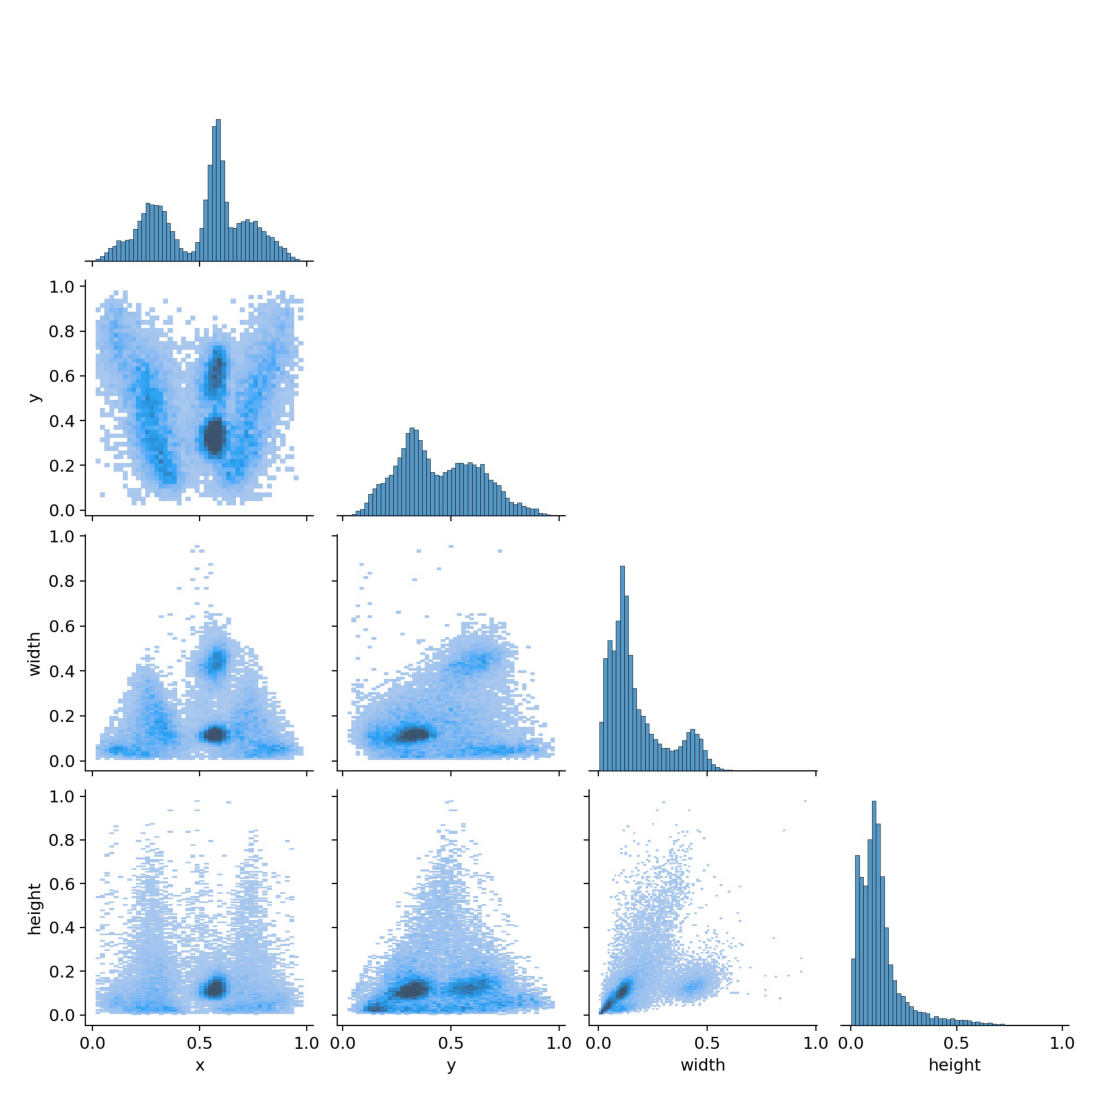

In [21]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

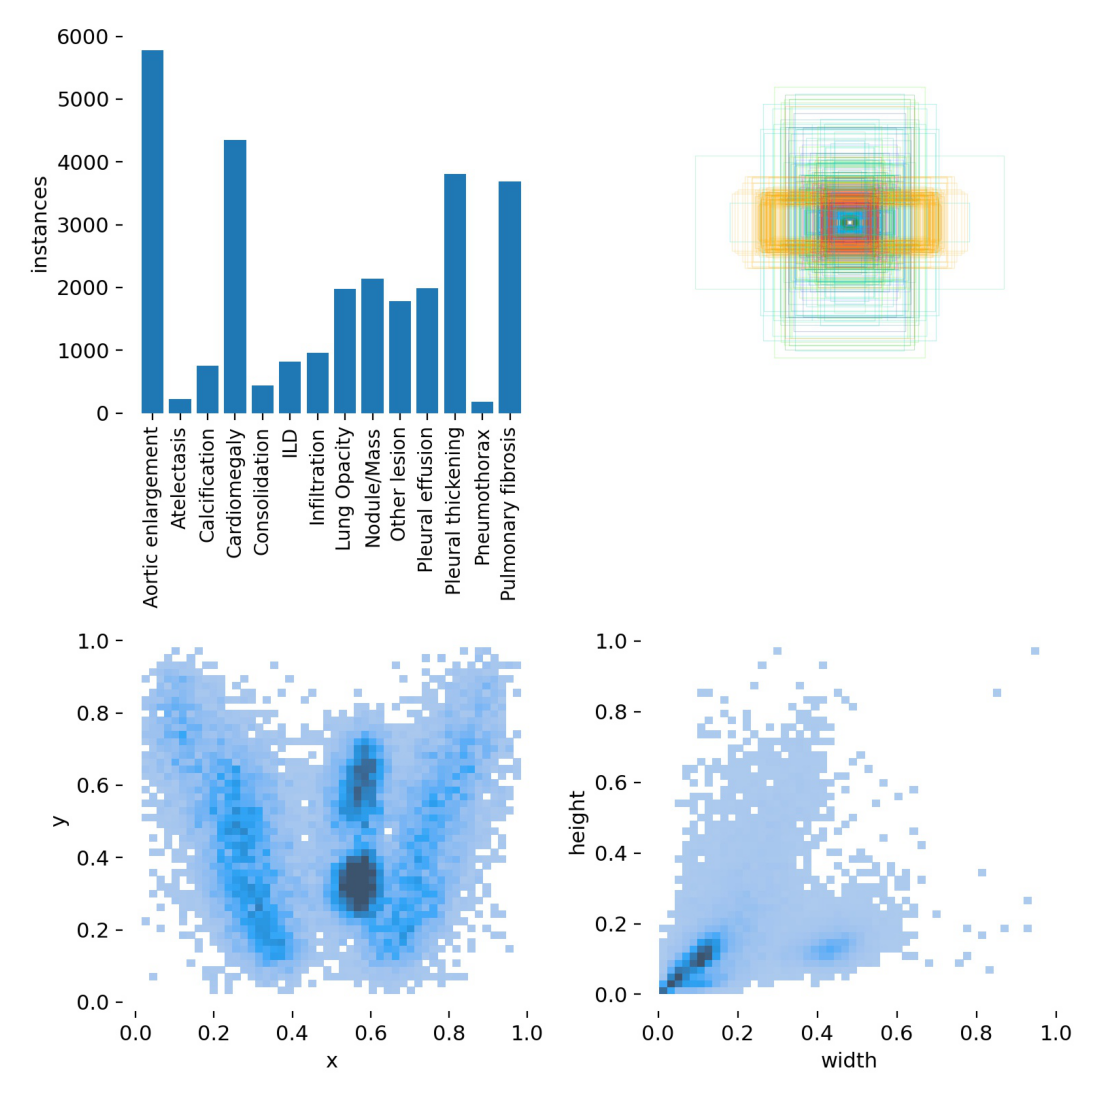

In [22]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

# (Loss, Map) Vs Epoch

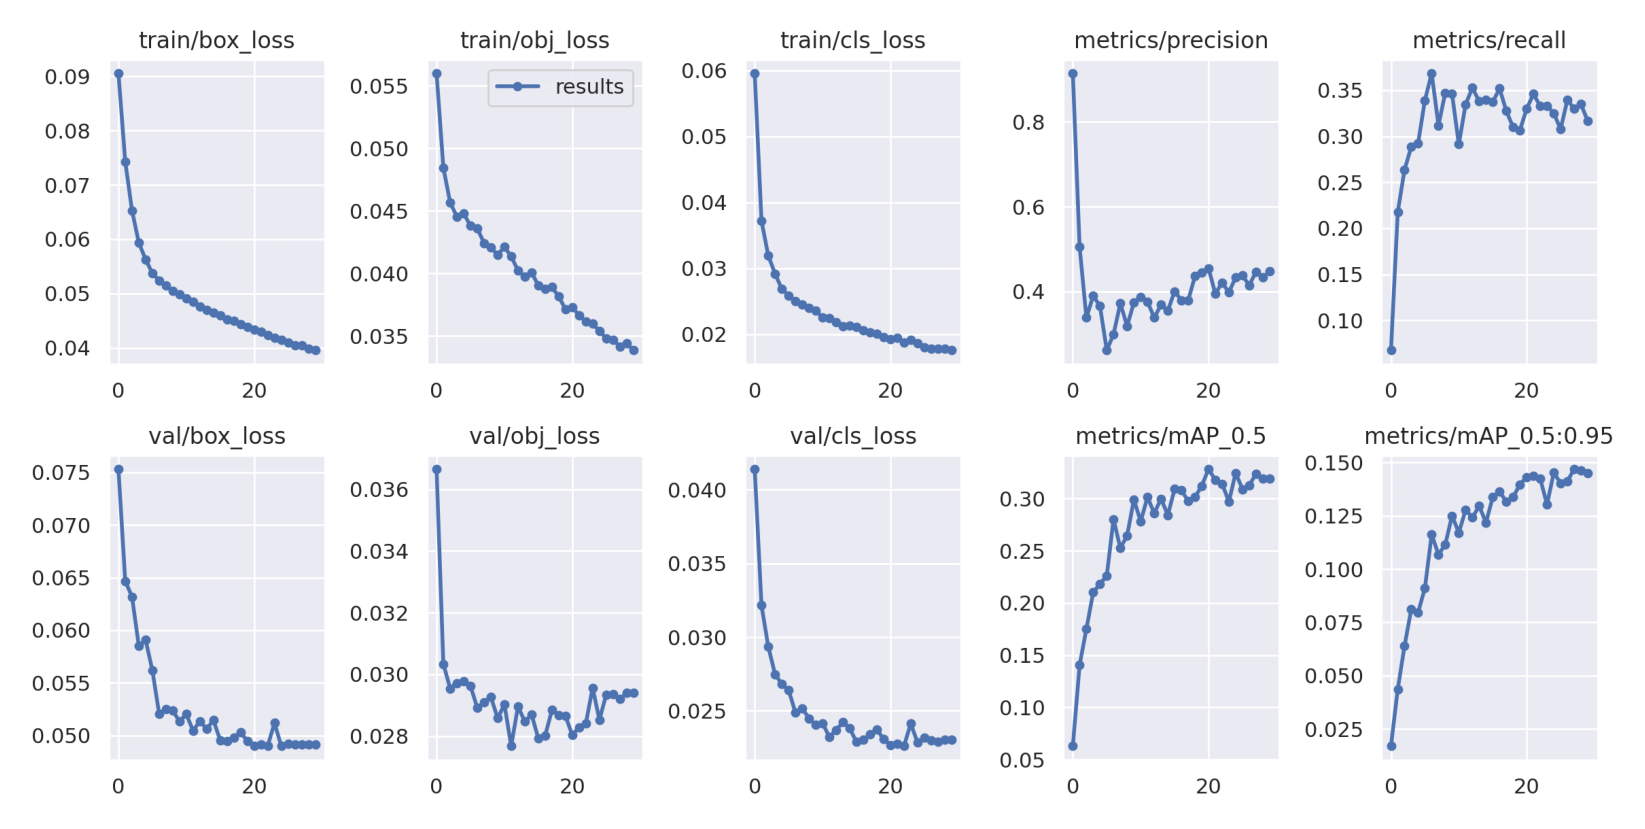

In [23]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

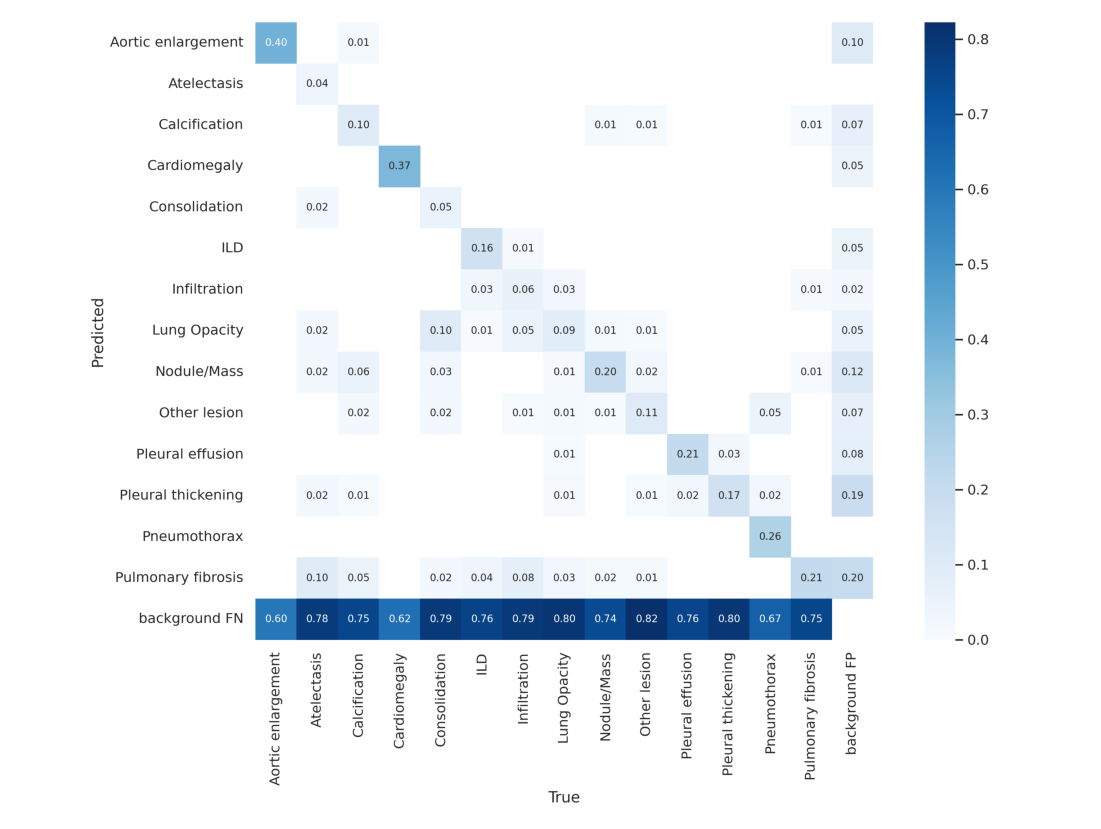

In [24]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference

In [28]:
!python detect.py --weights /content/Train_YOLOv5_ColabPro/yolov5/runs/train/exp/weights/best.pt --img 512 --conf 0.15 --source /content/Train_YOLOv5_ColabPro/images/val --exist-ok

detect: weights=['/content/Train_YOLOv5_ColabPro/yolov5/runs/train/exp/weights/best.pt'], source=/content/Train_YOLOv5_ColabPro/images/val, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-103-gc759bbd torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs
image 1/879 /content/Train_YOLOv5_ColabPro/images/val/00675cd546313f912cadd4ad54415d69.png: 512x512 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.056s)
image 2/879 /content/Train_YOLOv5_ColabPro/images/val/009d4c31ebf87e51c5c8c160a4bd8006.png: 512x512 1 Aortic enlargement, 1 Cardiomegaly, 1 Lung Opacity, 1 Pleu

In [29]:
from yolov5 import utils
display = utils.notebook_init() 

YOLOv5 🚀 v6.1-103-gc759bbd torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 46.0/166.8 GB disk)


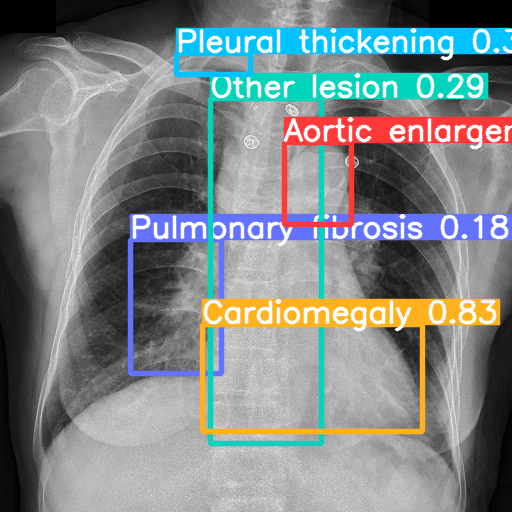

In [30]:
display.Image(filename='/content/Train_YOLOv5_ColabPro/yolov5/runs/detect/exp/0fca086ebe001f784d428aa9973ba691.png')

In [31]:
!python detect.py --weights /content/Train_YOLOv5_ColabPro/yolov5/runs/train/exp/weights/best.pt --img 512 --conf 0.15 --source /content/vinbigdata/test --save-txt --save-conf --exist-ok

detect: weights=['/content/Train_YOLOv5_ColabPro/yolov5/runs/train/exp/weights/best.pt'], source=/content/vinbigdata/test, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-103-gc759bbd torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs
image 1/3000 /content/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 512x512 1 Cardiomegaly, Done. (0.056s)
image 2/3000 /content/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 512x512 1 Aortic enlargement, Done. (0.040s)
image 3/3000 /content/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 512x512 1 Aortic enl

In [34]:
test_df = pd.read_csv('/content/vinbigdata/test.csv')
test_df.head(5)

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


In [35]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) 
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [36]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

  0%|          | 0/2159 [00:00<?, ?it/s]

In [37]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('submission_yolov5.csv',index = False)
sub_df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,0 0.2 1053 748 1323 979 3 0.7 806 1164 1746 1524
1,7550347fa2bb96c2354a3716dfa3a69c,5 0.4 1720 1124 2226 2218
2,74b23792db329cff5843e36efb8aa65a,8 0.2 1073 1133 1133 1194 8 0.3 719 1140 795 1...
3,94568a546be103177cb582d3e91cd2d8,11 0.2 689 712 892 788 0 0.8 974 1030 1215 134...
4,6da36354fc904b63bc03eb3884e0c35c,11 0.2 578 292 851 367 13 0.2 1546 743 1691 80...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,14 1 0 0 1 1
2996,c97e54a78bab9c05ce2e04fe6c284bcd,3 0.6 1368 1686 2418 2046 0 0.8 1704 972 2058 ...
2997,33218cf183c1224a74ccfb514e827e15,7 0.3 538 571 1077 1623 9 0.4 516 543 1081 1634
2998,04b700c4815f088728db9f093c739707,11 0.3 699 592 1053 688 0 0.4 1305 1065 1577 1340


In [38]:
from google.colab import files
files.download('/content/Train_YOLOv5_ColabPro/yolov5/submission_yolov5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# /content/gdrive/MyDrive/Weights YOLOv5/best.pt

# https://drive.google.com/drive/u/2/folders/1QdM5d4I33AhSAIkcMASns4DEIgHTHJjS